In [1]:
import pandas as pd
import numpy as np
import random
import json
import matplotlib.pyplot as plt

# Privacy Tests

In [3]:
df_train = pd.read_csv("../data/processed/sorted_train_data_mm.csv")
df_test = pd.read_csv("../data/processed/sorted_test_data_mm.csv")

synthetic_data_paths = [
    # These are the files that created by d-generation-process
    "../data/interim/privacy_testing/Monte_Carlo_Attack_Data/Epoch_1_synthdata_from_data_train_for_privacy.csv",
    "../data/interim/privacy_testing/Monte_Carlo_Attack_Data/Epoch_10_synthdata_from_data_train_for_privacy.csv",
    "../data/interim/privacy_testing/Monte_Carlo_Attack_Data/Epoch_50_synthdata_from_data_train_for_privacy.csv",
    "../data/interim/privacy_testing/Monte_Carlo_Attack_Data/Epoch_100_synthdata_from_data_train_for_privacy.csv",
    "../data/interim/privacy_testing/Monte_Carlo_Attack_Data/Epoch_150_synthdata_from_data_train_for_privacy.csv",
    "../data/interim/privacy_testing/Monte_Carlo_Attack_Data/Epoch_200_synthdata_from_data_train_for_privacy.csv",
    "../data/interim/privacy_testing/Monte_Carlo_Attack_Data/Epoch_250_synthdata_from_data_train_for_privacy.csv",
]

file_names = [path.split("/")[-1].split(".")[0] for path in synthetic_data_paths]

In [3]:
synth_data_dict = {}

for path, file_name in zip(synthetic_data_paths, file_names):
    synth_data_dict[file_name] = pd.read_csv(path)

# Monte-Carlo Attack 

Hilprecht, B., Härterich, M., & Bernau, D. (2019, June 7). Reconstruction and Membership Inference Attacks against Generative Models. http://arxiv.org/pdf/1906.03006 

## Calculating the 0.1 percentile distance

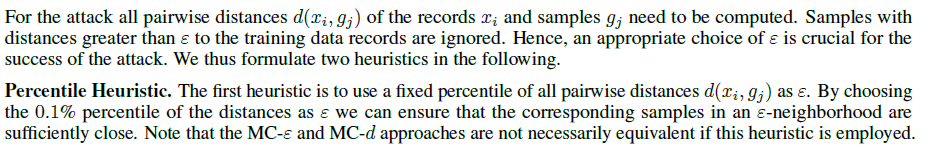

In [4]:
def calculate_percentile(synthetic_data, suspected_train_data):

    """
    Calculate the 0.1 percentile of distances between each row of sampled_data and df_train_cut,
    and print the progress steps.

    Args:
        sampled_data (DataFrame): DataFrame containing sampled data.
        df_train_cut (DataFrame): DataFrame containing training data.

    Returns:
        float: The 0.1 percentile of distances.
    """
    a = 0
    distance_list = []

    print(f"There will be {len(synthetic_data)} steps")

    for index, row1 in synthetic_data.iterrows():

        a += 1
        for index, row2 in suspected_train_data.iterrows():
            distance_list.append(np.linalg.norm(row1 - row2))

        print(a)

    percentile_01 = np.percentile(distance_list, 0.1)
    
    print("0.1 percentile:", percentile_01)

    return percentile_01

In [5]:
df_train_sample = df_train.sample(n=200, random_state=42)
df_test_sample = df_test.sample(n=200, random_state=42) 

In [10]:
percentile_dict = {}
for key in synth_data_dict:
    sample = synth_data_dict[key].sample(n=2000, random_state=42) 
    percentile_dict[key] = calculate_percentile(sample, df_train_sample)

In [ ]:
filename = "name"
with open(f"../data/interim/privacy_testing/{filename}", "w") as json_file:
    json.dump(percentile_dict, json_file)

print("Dictionary stored to file successfully.")

In [7]:
# # Load the dictionary from the file

# with open(
#     "../data/interim/privacy_testing/percentile_dict_data_random_sample", "r"
# ) as json_file:
#     percentile_dict = json.load(json_file)

### Choosing the training and testing samples in order to figure out the rightly choosen train data proportion
### Single MI

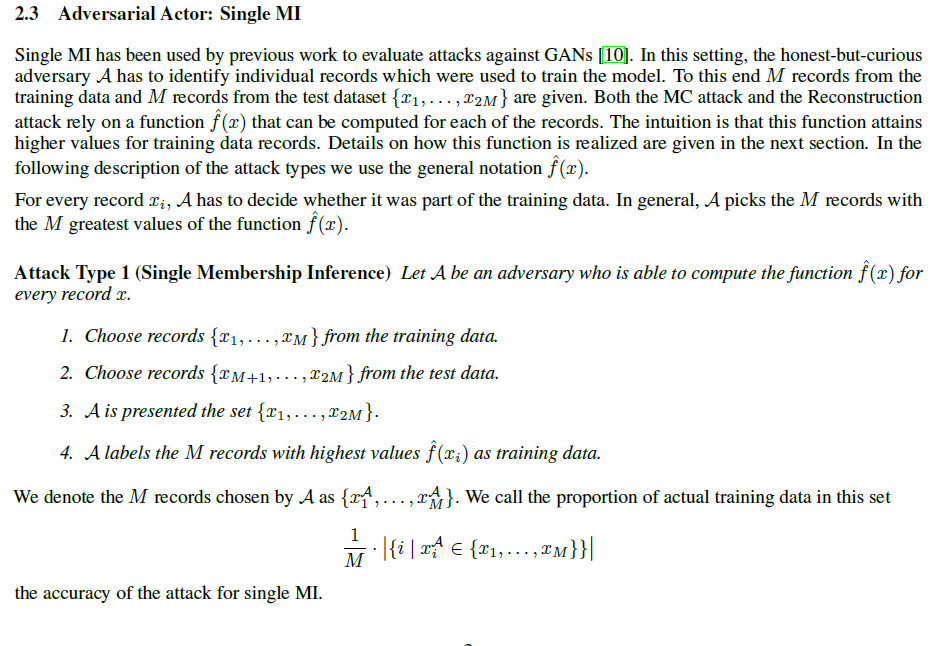

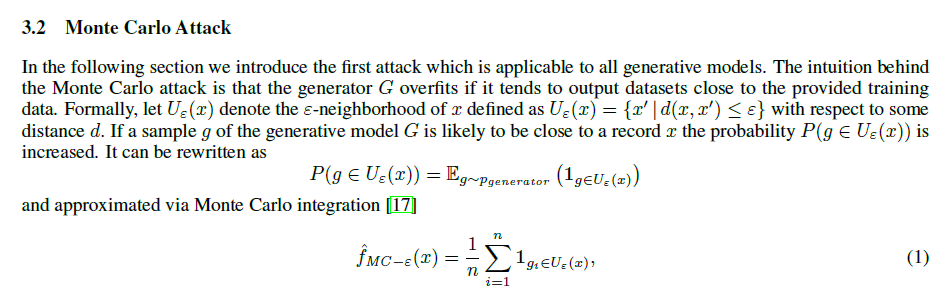

In [9]:
def calculate_distance_list(df_synth, suspected_df_train):
    """
    Calculate the euclidean distances between each row of the sample and each row of the training data.

    Args:
        df_synth (DataFrame): DataFrame containing the synthetic data.
        df_original (DataFrame): DataFrame containing the original (training) data.

    Returns:
        list: List containing the distances between each row of the sample and each row of the training data.
    """

    a = 0
    print(f"There will be {len(df_synth)} steps")

    distance_list = []
    for index, row1 in df_synth.iterrows():
        a += 1
        if a % 10 == 0:
            print(a)
        else:
            pass
        for index, row2 in suspected_df_train.iterrows():
            distance_list.append(np.linalg.norm(row1 - row2))

    return distance_list

### Indicator Function
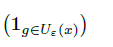

In [11]:
def indicator_function(distance_list, interval):
    """
    This is the index function. 1 if within e-environemnt
    0 if not
    """
    return [
        1 if np.abs(distance) < interval else 0 for distance in distance_list
    ]


In [ ]:
def sum_of_n_steps(distance_list, lenght_original_list):

    """
    Calculate the sum of how often a row of the sample is within the €-environment.

    Args:
        distance_list (list): A list of distances between each row of the sample and
        each row of the original training data. (see calculate_distance_list)
        length_original_list (int): The length of each step.

    Returns:
        list: A list containing the sum of samples within the e-environment
        for each row of the sample data.

    """

    new_list = []
    for i in range(0, len(distance_list), lenght_original_list):
        sum_of_100 = sum(distance_list[i : i + lenght_original_list])
        
        # according to Hilprecht et al. (2019) this should be the probability. Yet it
        # However, in our case, we're dealing with the sum of many means with the same denominator.
        # Therefore, we use a value of the numerator instead of the mean value to simplify calculations.

        new_list.append(sum_of_100)
    return new_list

In [ ]:
def monte_carlo_attack(synth_df, df_train_sample, df_test_sample, interval):

    lenght_synth_df = len(synth_df)

    distance_list_train = []
    # calculation the distance between the train data sample and the original train data
    distance_list_train = calculate_distance_list(df_train_sample, synth_df)
    # print(distance_list_train[200:400])

    # combined index function and sum of it.
    order_train_function_list = sum_of_n_steps(
        indicator_function(distance_list_train, interval), lenght_synth_df
    )

    # appyling the values of f(x) to the sample and adding an identifier
    df_train_sample["function_values"] = order_train_function_list
    df_train_sample['identifier'] = 1

    distance_list_test = []
    # calculation the distance between the test data sample and the test train data
    distance_list_test = calculate_distance_list(df_test_sample, synth_df)
    # combined index function and sum of it.
    order_test_function_list = sum_of_n_steps(
        indicator_function(distance_list_test, interval), lenght_synth_df
    )

    # appyling the values of the f(x) to the sample and adding an identifier
    df_test_sample["function_values"] = order_test_function_list
    df_test_sample["identifier"] = 0

    df_concat = pd.concat([df_train_sample, df_test_sample], ignore_index=True)
    
    # here it is important to find out if there are more then M positive function values
    # if not, another calculation method needs to be applied.
    if len(df_concat.query("function_values > 0")) > len(df_train_sample):
        
        # single_mi
        df_sorted = df_concat.sort_values("function_values", ascending=False)
        df_sorted_half = df_sorted.head(len(df_train_sample))
        rightly_choosen_samples = sum(df_sorted_half.identifier)
        accuracy = rightly_choosen_samples / len(df_train_sample)
        M_bigger_then_half = True

        # set_mi
        if accuracy > 0.5:
            right_set_choosen = True
        else:
            right_set_choosen = False
    
    else: 
        # single_mi
        rightly_choosen_samples = sum(df_concat.query("function_values > 0").identifier)
        accuracy = rightly_choosen_samples / len(df_train_sample)
        M_bigger_then_half = False

        # set_mi
        percentage_of_right_set =  sum(df_concat.query("function_values > 0").identifier) / len(df_concat.query("function_values > 0"))
        if percentage_of_right_set > 0.5:
            right_set_choosen = True
        else:
            right_set_choosen = False

    return df_concat, rightly_choosen_samples, accuracy, distance_list_train, distance_list_test, M_bigger_then_half, right_set_choosen

In [ ]:
analyis_dict = {}
for key in percentile_dict:

    analyis_dict[key] = {}

    (df_concat, rightly_choosen_samples, accuracy, percentage_of_right_class, distance_list_train, distance_list_test) = monte_carlo_attack(synth_data_dict[key].sample(n=2000, random_state=42), df_train_sample, df_test_sample, percentile_dict[key])

    analyis_dict[key]['df'] = df_concat
    analyis_dict[key]['rightly_choosen_samples'] = rightly_choosen_samples
    analyis_dict[key]['accuracy'] = accuracy
    analyis_dict[key]['percentage_of_right_class'] = percentage_of_right_class
    analyis_dict[key]["distance_list_train"] = distance_list_train
    analyis_dict[key]["distance_list_test"] = distance_list_test

    print(rightly_choosen_samples, accuracy, percentage_of_right_class)